# Trading env tester
### This notebook explores an openai trading env for BTC ohcv data
<hr>

#### -Pulls custom signal and historical data from BWA portmaker module
##### -Applies ML and RL to trading env for backtesting


### Imports
<hr>

In [64]:
import random
import json
import gym
from gym import spaces
import pandas as pd
import numpy as np
import datetime as dt
#from env.TradingEnv import TradingEnv
import portmaker
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
import plotly.graph_objects as go

from plotly.subplots import make_subplots
import plotly.tools as tls
import plotly

def plot_signal(signal,save_plot=False):
    
    xs = signal.index
    print(signal.iloc[0])
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(go.Scatter(x=xs, y=signal['Close'], name="Close"))

    fig.add_trace(go.Scatter(x=xs, y=signal['2'], name="High"))
    fig.add_trace(go.Scatter(x=xs, y=signal['-2'], name="Low"))
    fig.add_trace(go.Scatter(x=xs, y=signal['Position'], name="Signal",)
    ,secondary_y=True)

    fig.layout.update(title='BTC Signal')#,xaxis_rangeslider_visible=True)
    # Set x-axis title
    fig.update_xaxes(title_text="Date")

    # Set y-axes titles
    fig.update_yaxes(title_text="<b>Price</b> ", secondary_y=False)
    fig.update_yaxes(title_text="<b>Signal</b>", secondary_y=True)
    loc = '/home/me/Documents/BWA_dash/images/btc_signal.html'
    loc2 = '/BWA/out/images/btc_signal.html'
    if save_plot:
        plotly.offline.plot(fig, filename=loc)
    #fig.show()
    return fig
    
def get_returns(all_sigs): 
    all_sigs['Market Return'] = np.log(all_sigs["Close"] / all_sigs["Close"].shift(1))
    all_sigs['Strategy Return'] = all_sigs['Market Return'] * all_sigs['Position']
    all_sigs['Strategy Return'] = all_sigs['Strategy Return'].cumsum()
    return all_sigs

def plot_returns(all_sigs,save_plot=False):
    print(all_sigs.columns)   
    xs = all_sigs.index
    print(xs)
    xs = all_sigs.index
    all_sigs['Market Return'] = np.log(all_sigs["Close"] / all_sigs["Close"].shift(1))
    all_sigs['Strategy Return'] = all_sigs['Market Return'] * all_sigs['Position']
    #all_sigs['Strategy2 Return'] = all_sigs['Market Return'] * all_sigs['Position2']
    #all_sigs['Strategy3 Return'] = all_sigs['Market Return'] * all_sigs['Position3']
                                                                       
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=xs, y=all_sigs['Strategy Return'].cumsum()*100, name="Returns", line_color='deepskyblue'))
    #fig.add_trace(go.Scatter(x=prices.index, y=all_sigs['Strategy2 Return'].cumsum()*100, name="Returns2"))
    #fig.add_trace(go.Scatter(x=prices.index, y=all_sigs['Strategy3 Return'].cumsum()*100, name="Returns3"))

    fig.add_trace(go.Scatter(x=xs, y=all_sigs['Market Return'].cumsum()*100, name="Market Returns", line_color='red'))
    fig.update_layout(title_text='Returns',
                  xaxis_rangeslider_visible=True)
    loc = '/home/me/Documents/BWA_dash/images/btc_returns.html'
    loc2 = '/BWA/out/images/btc_returns.html'
    if save_plot:
        plotly.offline.plot(fig, filename=loc)
    return fig
def make_plots():
    #ssh = paramiko.SSHClient()
    #ssh.connect('159.203.174.22', username="root", password="sonicrules12")
    #ssh_stdin, ssh_stdout, ssh_stderr = ssh.exec_command(r'scp -r :/root/BWA/out/btc_signal.csv /home/me/Documents/BWA_dash/')
    live_sig = pd.read_csv("/home/me/Documents/BWA_dash/local_sig.csv")
    live_sig = live_sig.drop_duplicates()
    print(live_sig.tail(3))
    #d = 14
    #i = 12*24*d
    all_sigs = get_returns(live_sig)
    #all_sigs["Close time"] = all_sigs["Close time"].astype('datetime64[s]')
    all_sigs = all_sigs.set_index("Open time") 

    ret = all_sigs["Strategy Return"].iloc[-1]*100
    ret = round(float(ret),2)
    print("All time returns: {}% btc balance".format(ret))
    ld = all_sigs.index.values
    print("Last datetime entered: {}".format(ld[-1]))
    print("Last signal: ", all_sigs["Position"].iloc[-1])
    print("Current datetime: ",portmaker.to_dt(int(portmaker.current_milli_time())))
    sig_plot = plot_signal(all_sigs, save_plot=True)
    return_plot = plot_returns(all_sigs)
    return sig_plot



## Test trading gym env class 
<hr>

In [70]:

MAX_STEPS = 20000
class TradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df):
        super(TradingEnv, self).__init__()
        self.last_sig = 0
        self.usdt_holdings = 1000
        self.btc_holdings = 0
        self.current_step = 0
        self.prev_usdt,self.prev_btc = 0,0
        #self.init_btc = self.btc_holdings
        self.max_btc = 0
        self.max_usdt = 0
        self.btc_returns = 0
        self.current_act = 0
        self.trades = pd.DataFrame()
        self.dates = df["Close time"]
        self.last_entry = 0
        self.last_exit = 0
        self.last_entry_t = 0
        self.last_exit_t = 0
        

        self.df = df
        # Actions of the format Buy x%, Sell x%, Hold, etc.
        self.action_space = spaces.Box(
            low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float16)

        # Prices contains the OHCL values for the last five prices
        self.observation_space = spaces.Box(
            low=0, high=1, shape=(6, 6), dtype=np.float16)
        

    def _next_observation(self):
        # Get the hist data at step
        frame = np.array([
            self.df["Open"].iloc[self.current_step],
            self.df["High"].iloc[self.current_step],
            self.df["Low"].iloc[self.current_step],
            self.df["Close"].iloc[self.current_step],
            self.df["Volume"].iloc[self.current_step],
        ])
        return frame

    def _take_action(self, action):
        #nested buy sell functions
        def buy():
            #update trade df
            trade_stamp = self.df.index.values[self.current_step]
            trade = pd.DataFrame({"Date":trade_stamp,"USDT":int(self.usdt_holdings),"BTC":self.btc_holdings,"Type":"BUY","Price":current_price},index=[0])
            self.trades = pd.concat([self.trades,trade])
            #set last entry to current price
            self.last_entry = current_price
            # Buy amount % of balance in shares
            total_possible = float(self.usdt_holdings / current_price)
            #deduct spent usdt from usdt_holdings 
            self.usdt_holdings = self.usdt_holdings -(total_possible*current_price)
            total_possible = round(total_possible,5)
            #update balances
            self.btc_holdings = total_possible
            #update max btc held
            if total_possible > self.max_btc:
                self.max_btc = self.btc_holdings
            print("Buy {}btc at {}".format(total_possible,str(current_price)))
            
        def sell():
            #update trades df
            trade_stamp = self.df.index.values[self.current_step]
            trade = pd.DataFrame({"Date":trade_stamp,"USDT":int(self.usdt_holdings),"BTC":self.btc_holdings,"Type":"SELL","Price":current_price},index=[0])
            self.trades = pd.concat([self.trades,trade])
            
            self.last_exit = current_price
            total_possible = float(self.btc_holdings)#/float(last_price["bidPrice"])
            print("Sell {} btc at {}".format(total_possible,df["Close"].iloc[self.current_step]))
            #update balances
            self.btc_holdings = self.btc_holdings -self.btc_holdings
            self.usdt_holdings = float(total_possible*current_price)
            
        # Set the current price to a random price within the current time step
        current_price = random.uniform(self.df["Open"].iloc[self.current_step], self.df["Close"].iloc[self.current_step])
        #print(current_price,self.df["Open"].iloc[self.current_step])
        action_type = action[0]
        self.current_act = action_type
        #external purchase quantity
        amount = action[1]
        """
        BUY BTC
        ==============
        Conditions are:
        -if action is buy
        -has usdt to buy btc
        -current signal is not a same as previous signal
        -has no btc
        ==============
        """
        
            
            
        if (action_type > 0 and self.usdt_holdings !=0 and self.last_sig!=action_type and self.btc_holdings ==0):
            #overtrading limiter 2
            td = current_price/self.last_entry
            if(td > .99 and td < 1.01):
                print("no trades", self.df.index.values[self.current_step],self.current_step)
            else:
                buy()
            

        elif (action_type < 0 and self.btc_holdings !=0 and self.last_sig!=action_type):
            # Buy amount % of balance in shares
            td = current_price/self.last_entry
            if(td > .99 and td < 1.01):
                print("no trades", self.df.index.values[self.current_step],self.current_step)
                #df["Position"].iloc[self.current_step]
            else:
                sell()
                
                
        
            if self.usdt_holdings > self.max_usdt:
                self.max_usdt = self.usdt_holdings
            #print("Selling {}btc at {}".format(total_possible,str(current_price)))
            #print("{} remaining usdt".format(self.usdt_holdings))
            #print("\n====\n")
            
            
        self.last_sig  = action[0]
        if(self.btc_holdings!=0):
            self.btc_net = (self.btc_holdings/self.init_btc)*100

        if self.btc_holdings > self.max_btc:
            self.max_btc = self.btc_holdings
        if self.btc_holdings>0:
            curr_profit = (self.btc_holdings/ self.init_btc)
            #print(self.btc_holdings,self.init_btc)
        else:
            #print("USDT: {}  Init btc: {}".format(self.usdt_holdings,self.init_btc))
            
                #print("USDT: {}  Init btc: {}".format(self.usdt_holdings,self.init_btc))
            self.prev_usdt,self.prev_btc = self.usdt_holdings,self.btc_holdings
            #print("Current profit: ",curr_profit)"""


    def step(self, action):
        # Execute one time step within the environment
        self._take_action(action)

        self.current_step += 1

        if self.current_step > len(self.df['Open'].values) - 6:
            self.current_step = 0

        delay_modifier = (self.current_step / MAX_STEPS)

        #reward = self.btc_net
        done = (self.btc_holdings/self.init_btc == 0 and self.usdt_holdings==0)

        obs = self._next_observation()

        return obs,  done, {}

    def reset(self):
        # Reset the state of the environment to an initial state
        self.usdt_holdings = 1000
        self.btc_holdings = 0
        self.max_usdt = self.usdt_holdings
        self.max_btc = 0
        self.max_usdt = 0
        self.btc_returns = 0
        self.current_act = 0
        self.init_btc = (self.usdt_holdings/df['Open'].iloc[self.current_step])
        self.init_usdt = self.usdt_holdings
        self.trades = pd.DataFrame()
        self.last_entry = 0
        self.last_exit = 0
        self.last_entry_t = 0
        self.last_exit_t = 0

        # Set the current step to a random point within the data frame
        #print(self.df.columns)
        self.current_step = 0#random.randint(0, len(self.df['Open'].values) - 6)

        return self._next_observation()

    def render(self, mode='human', close=False):
        # Render the environment to the screen
        profit = (self.btc_holdings/ self.init_btc)
        if(profit>0):
            profit*=100
        else:
            profit = (1-profit)
        max_curr = (self.max_btc*self.df['Open'].iloc[-1])
        
        
        print(f'Step: {self.current_step}')
        print("Timestamp: ",portmaker.to_dt(self.df["Close time"].iloc[self.current_step]))
        print("-------------")
        print(f'Current BTC Balance: {self.btc_holdings}')
        print("Init BTC: ",self.init_btc)
        print("-------------")
        print("Current USDT Balance: {}".format(self.usdt_holdings))
        print("Init USDT: ",self.init_usdt)
        print("-------------")
        print("-------------")
        print('Max usdt: {}'.format(self.max_usdt))
        print(f'Max btc: {self.max_btc}')
        print('Max btc at current price: {}'.format(max_curr))
        #print(f'Profit: {profit}')
        if(self.current_step == len(df)-8):
            make_plots()
        #print(df.iloc[self.current_step].index)

## Get data and signal from portmaker module
<hr>

#####  -Applies BWA signal to ohlcv df for optional ML optimization
##### -Gets data from -n*day to current time using unixtime time for serve communication</b>



# The algorithms require a vectorized environment to run


# Creating the Env with OHLCV data frame
<hr>

#### -Model fitting and training called here
##### -Acces live balances via env.trades

In [71]:
"""
end = int(portmaker.current_milli_time())
d_intv = 30
st = end-(86400000*d_intv)
coin = "BTCUSDT"
candle_k='5m'
data = portmaker.get_data(coin,st,end,candle_k)
t1 = portmaker.current_milli_time()
all_prices,df = portmaker.get_intv(data,coin,d_intv,candle_k)
#print(df.columns)
all_sigs = df.set_index("Close time")
print(all_sigs.head(3))
"""
#get live bot data
!scp -r root@159.203.174.22:/root/BWA/out/btc_signal.csv /home/me/Documents/BWA_dash/
live_sig = pd.read_csv("/home/me/Documents/BWA_dash/btc_signal.csv")
live_sig = live_sig.drop_duplicates()
#print(live_sig.tail(3))
df = live_sig.set_index("Open time")
#"""

btc_signal.csv                                100%  933KB 833.2KB/s   00:01    


In [84]:

#df = pd.read_csv("/home/me/Documents/BWA_dash/local_sig.csv")
env = TradingEnv(df)
print("Action shape: ",env.action_space.shape)
print("State shape: ",env.observation_space.shape)

#specify max length of each episode
max_iter = len(df)+6
#reset env to default state
#starts with $1000 ...will edit for input
obs = env.reset()
rc = 1
trades = None
dates = env.dates
lt = None
balances = None
#loop through iterations
for i in range(max_iter):
    #random agent
    rand_agent = np.random.randint(-1,2)
    #BWA signal agent/actor
    BWA_sig = env.df.Position.iloc[env.current_step]
    trades = env.trades
    
    
    if(len(trades)!= lt):
        lt = len(trades)
        print(trades)
        print("{} trades taken".format(lt))
        print("\n========================\n")
        #balances =  env.render()
        
        #print(type(balances))
    #print(rc==(max_iter),rc)
    """if(rc%500==0 or rc==max_iter):
        print("\n========================\n")
        balances =  env.render()"""
    
    #random agent for testing
    #obs, done, info = env.step([rand_agent,1])
    
    #portmaker signal for benchmark
    obs, done, info = env.step([BWA_sig,1])
    rc+=1
    

Action shape:  (2,)
State shape:  (6, 6)
Empty DataFrame
Columns: []
Index: []
0 trades taken


Buy 0.09684btc at 10326.094074272656
                  Date  USDT  BTC Type         Price
0  2019-08-17 12:58:00  1000    0  BUY  10326.094074
1 trades taken


no trades 2019-08-17 13:00:00 8
no trades 2019-08-17 13:13:00 21
no trades 2019-08-17 13:18:00 26
no trades 2019-08-17 13:37:00 45
no trades 2019-08-17 13:56:00 64
no trades 2019-08-17 14:02:00 70
no trades 2019-08-17 14:12:00 80
no trades 2019-08-17 14:26:00 94
no trades 2019-08-17 14:58:00 126
no trades 2019-08-17 15:19:00 147
no trades 2019-08-17 15:54:00 182
no trades 2019-08-17 16:00:00 188
no trades 2019-08-17 16:02:00 190
no trades 2019-08-17 16:05:00 193
no trades 2019-08-17 16:08:00 196
no trades 2019-08-17 16:14:00 202
no trades 2019-08-17 16:19:00 207
no trades 2019-08-17 16:48:00 236
no trades 2019-08-17 16:53:00 241
Sell 0.09684 btc at 10187.0
                  Date  USDT      BTC  Type         Price
0  2019-08-17 12:58:0

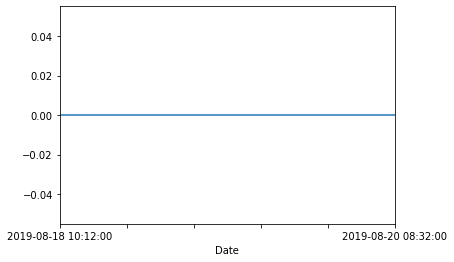

In [38]:

def vis(df):
    cp = df.copy()
    cp.set_index("Date",inplace=True)
    cp["USDT"].plot()
vis(trades.copy())
#print(trades.values[:,0])
#for i in trades.values:
#    print(i[0])
#trades["USDT"]

In [39]:
trades

,Date,USDT,BTC
0,2019-08-18 10:12:00,0.0,0.09937
0,2019-08-20 08:32:00,0.0,0.09808


In [ ]:
df.to_csv('/home/me/Documents/BWA_dash/local_sig.csv')